In [9]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time
import math

from datetime import datetime

# Main Algorithm

In [10]:
def compute_switch_over(tilde_m, tilde_m_squared):
    m = 1
    
    coordinates_queue_centers = []
    for j in range(tilde_m)[::-1]:
        for i in range(tilde_m):
            coordinates_queue_centers.append([round((1/(tilde_m+tilde_m)) + (i/tilde_m),14), round((1/(tilde_m+tilde_m)) + (j/tilde_m),14)])
    
    theta = np.zeros((tilde_m_squared+1, tilde_m_squared+1), dtype=float)
    for i in range(tilde_m_squared+1):
        for j in range(tilde_m_squared+1):
            if (i == 0 and j > 0):
                distance = np.sqrt((((m/2) - coordinates_queue_centers[j-1][0])**2) + (((m/2) - coordinates_queue_centers[j-1][1])**2))
                theta[i][j] = round(distance, 14)
                theta[j][i] = round(distance, 14)
            elif (i < j):
                distance = np.sqrt(((coordinates_queue_centers[i-1][0] - coordinates_queue_centers[j-1][0])**2) + ((coordinates_queue_centers[i-1][1] - coordinates_queue_centers[j-1][1])**2))
                theta[i][j] = round(distance, 14)
                theta[j][i] = round(distance, 14)

    return theta, coordinates_queue_centers

tilde_m = 2
tilde_m_squared = tilde_m**2; # Number of subregion in A

if (tilde_m % 2 != 0):
    raise ValueError(f"tilde_m must be even")

theta_incl, coordinates_queue_centers = compute_switch_over(tilde_m, tilde_m_squared)

In [11]:
def prep_TSP(tilde_n_I, theta, current_queue_index, status_traveler):
    
    if (status_traveler == 1):
        I_min = [current_queue_index]
        tilde_n_min = [0]
    else:
        I_min = [0]
        tilde_n_min = [0] 
        
    for i in range(len(tilde_n_I)):
        if (tilde_n_I[i] > 0):
            I_min.append(i+1)    
            tilde_n_min.append(tilde_n_I[i])

    theta_min = []
    for x in I_min:
        theta_min_row=[]
        for y in I_min:
            distance_theta = theta[x][y]
            theta_min_row.append(distance_theta)
        theta_min.append(theta_min_row)

    return I_min, tilde_n_min, theta_min

def compute_queue_index(x_coordinate, y_coordinate):
    global tilde_m; global m; global coordinates_queue_centers
    m=1
    
    for i in range(1,tilde_m+1):
        if (x_coordinate <= i*(m/tilde_m)):
            column_index = i;
            break
    
    iter = 1
    for j in range(0,tilde_m)[::-1]:
        if (y_coordinate >= j*(m/tilde_m)):
            row_index = iter;
            break
        iter += 1
            
    queue_index = column_index + ((row_index-1)*tilde_m);
    
    return queue_index;

class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival
        queue_index = compute_queue_index(x_coordinate,y_coordinate)
        self.queue_index = queue_index
        
class result:
    def __init__(self, index, earliest_arrival, completion_time, waiting_time, system_time):
        self.index = index
        self.earliest_arrival = earliest_arrival
        self.completion_time = completion_time
        self.waiting_time = waiting_time
        self.system_time = system_time

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    global all_demands
    np.random.seed(number_nodes_in_system) # TRY
    A = np.random.exponential(scale = 1/lam, size=1)[0];
    S = np.random.uniform(0, 1, size = 1)[0]
    X = np.random.uniform(low=0, high=m, size=1)[0];
    Y = np.random.uniform(low=0, high=m, size=1)[0];
    demand = demand_object(number_nodes_in_system+1, A, X, Y, S, lower_earliest + A);
    all_demands[number_nodes_in_system] = demand
    return demand;

def add_newly_appeared(available_nodes, maximum_time):
    global number_available_nodes_queue
    global number_nodes_in_system
    global lower_earliest
    global simulation_demands_amount
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= maximum_time):
            temp_queue_index = new_available_node.queue_index
            available_nodes[temp_queue_index-1].append(new_available_node);
            number_available_nodes_queue[temp_queue_index-1] += 1;
            number_nodes_in_system += 1;
            lower_earliest = new_available_node.earliest_arrival;
        else:
            break;
            
    return available_nodes;

def determine_Nearest_Neighbor(available_nodes_queue, number_available_nodes_queue, current_node, status_traveler, coordinates_queue_centers, current_queue_index):
    minimum_distance = float('inf');
    
    if (status_traveler == 0):
        for i in range(number_available_nodes_queue):
            temp_distance = np.sqrt((coordinates_queue_centers[current_queue_index-1][0] - available_nodes_queue[i].x_coordinate)**2 + (coordinates_queue_centers[current_queue_index-1][1] - available_nodes_queue[i].y_coordinate)**2); 
            if (temp_distance < minimum_distance):
                next_node = available_nodes_queue[i];
                minimum_distance = temp_distance;
    else:
        for i in range(number_available_nodes_queue):
            temp_distance = np.sqrt((current_node.x_coordinate - available_nodes_queue[i].x_coordinate)**2 + (current_node.y_coordinate - available_nodes_queue[i].y_coordinate)**2);  
            if (temp_distance < minimum_distance):
                next_node = available_nodes_queue[i];
                minimum_distance = temp_distance;
    
    travel_time = minimum_distance
    return next_node, travel_time;



def determine_next_queue_index(current_queue_index, number_available_nodes_queue):
    while (number_available_nodes_queue[current_queue_index-1] == 0):
        if (current_queue_index < tilde_m):
            current_queue_index += 1
        
        elif(current_queue_index % tilde_m == 1):
            current_queue_index -= tilde_m
        
        elif(current_queue_index % tilde_m == 0 and math.floor(current_queue_index/tilde_m) % 2 == 1 and current_queue_index != tilde_m**2):
            current_queue_index += tilde_m
        
        elif(current_queue_index % tilde_m == 2 and math.floor(current_queue_index/tilde_m) % 2 == 1 and current_queue_index != (tilde_m**2-tilde_m+2)):
            current_queue_index += tilde_m
            
        elif (math.floor(current_queue_index/tilde_m)%2 == 1 or current_queue_index % tilde_m == 0):
            current_queue_index -= 1
            
        elif (math.floor(current_queue_index/tilde_m)%2 == 0):
            current_queue_index += 1
        
    return current_queue_index
    

def simulate_PART_NN_algorithm(theta_incl, coordinates_queue_centers):
    global simulation_demands_amount; global m; global tilde_m; global tilde_m_squared;
    global number_available_nodes_queue; global number_nodes_in_system; global lower_earliest;
    global lam
    
    action_traveler = 0; # 0 = traveling to an available demand; 1 = travel to the depot
    status_traveler = 0; # 0 = at depot waiting; 1 = finished serving at a demand
    number_visited_nodes = 0;
    status_traveler = 0
    
    available_nodes = []; 
    for i in range(tilde_m_squared):
        available_nodes.append([])
        
    current_node = None
    current_time = 0.0;
    lower_earliest = 0.0;
    
    
    result_waiting_times_array = [0]*simulation_demands_amount
    
    arrival_rate_Q = lam/tilde_m_squared
    
    start_time_time = time.time()
    
    current_queue_index = 1 # start tour at queue 1
    
    while (number_visited_nodes < simulation_demands_amount):
        
        #"""STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        #"""STATUS PRINTING"""
        
        #"""Initialization"""        
        available_nodes = add_newly_appeared(available_nodes, current_time);
        
        time_waited_at_depot = 0
        
        if (sum(number_available_nodes_queue) == 0):
            next_node = wait_for_arrival();
            lower_earliest = next_node.earliest_arrival;
            current_queue_index = next_node.queue_index
            number_nodes_in_system += 1;
            
            if (status_traveler == 0):
                travel_time = np.sqrt((next_node.x_coordinate - (m/2))**2 + (next_node.y_coordinate - (m/2))**2)
                status_traveler = 1
            else: 
                travel_time = np.sqrt((next_node.x_coordinate - current_node.x_coordinate)**2 + (next_node.y_coordinate - current_node.y_coordinate)**2)

            time_waited_at_depot = next_node.earliest_arrival - current_time;
        elif (number_available_nodes_queue[current_queue_index-1] > 0): 
            # Determine NN within queue, serve every queue exhaustively  
            next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node, status_traveler, coordinates_queue_centers, current_queue_index);
            available_nodes[current_queue_index-1].remove(next_node);
            number_available_nodes_queue[current_queue_index-1] -= 1;
            
        elif (number_available_nodes_queue[current_queue_index-1] == 0): 
            prev_queue_index = current_queue_index
            current_queue_index = determine_next_queue_index(current_queue_index, number_available_nodes_queue)
            
            next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node, status_traveler, coordinates_queue_centers, current_queue_index);
            available_nodes[current_queue_index-1].remove(next_node);
            number_available_nodes_queue[current_queue_index-1] -= 1;
        
        travel_time += time_waited_at_depot 

        result_waiting_times_array[number_visited_nodes] = current_time + travel_time - next_node.earliest_arrival
        current_time += travel_time + next_node.service_time;
        current_node = next_node;
        number_visited_nodes += 1;
        status_traveler = 1

    return result_waiting_times_array

In [12]:
# parameters
system_loads = 0.5
simulation_demands_amount = 400000 # Maximum number of demands per simulation
m = 1 # Square region A has size m x m
mu = 1/2;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;

number_available_nodes_queue = [0]*tilde_m_squared;
number_nodes_in_system = 0;
lower_earliest = 0.0;
all_demands = [None]*simulation_demands_amount

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")

start_time = time.time() # START TIME

result_waiting_times_array = simulate_PART_NN_algorithm(theta_incl, coordinates_queue_centers);

print(f"I have finished in {(time.time() - start_time)/60} minutes")

Starting time = 13:13:21
I have finished in 0.35478142102559407 minutes


## Results - Waiting Times - Batch Means

In [13]:
if (simulation_demands_amount == 400000):
    warm_up_period_min = 200000
    warm_up_period_max = 320000
    sample_size = 3000
else:
    raise ValueError(f"Invalid simulation amount")

number_of_samples = int((warm_up_period_max-warm_up_period_min)/sample_size)
print(f"number of samples = {number_of_samples}")

batch_sample = []

for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
    
CI = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
variation = (statistics.stdev(batch_sample))

print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Sigma waiting time = {variation:.4f}")
print(f"Waiting time CI = [{CI[0]:.4f},{CI[1]:.4f}]")

number of samples = 40
Waiting time mean = 2.6442
Sigma waiting time = 0.1528
Waiting time CI = [2.5968,2.6915]


# Plotting

In [14]:
convergence = []
convergence_sum = 0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

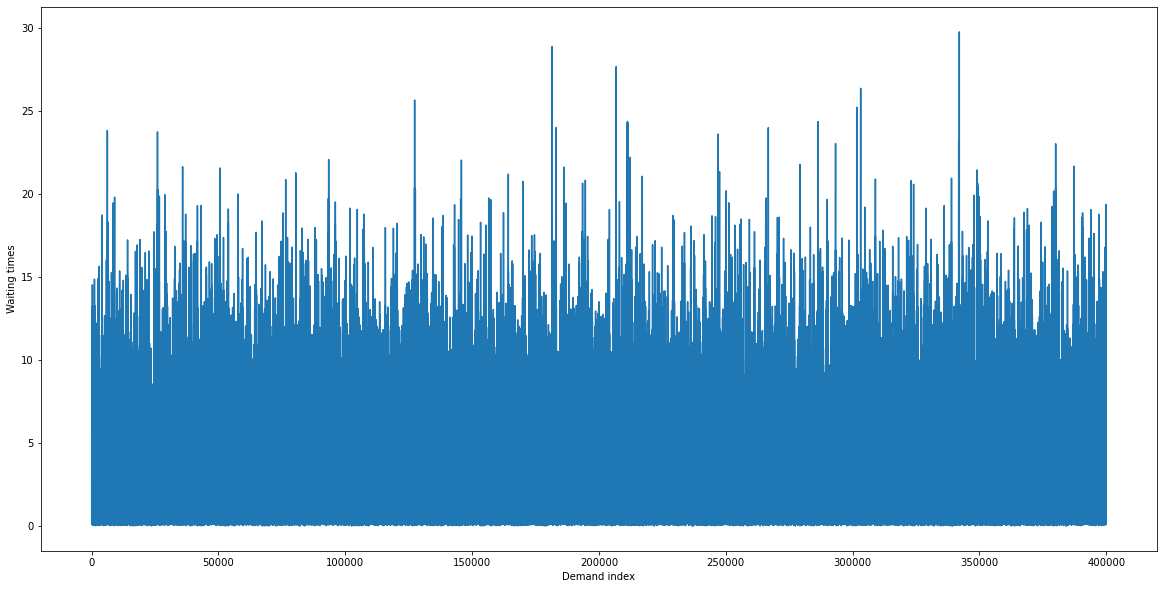

In [15]:
plt.figure(figsize=(20, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

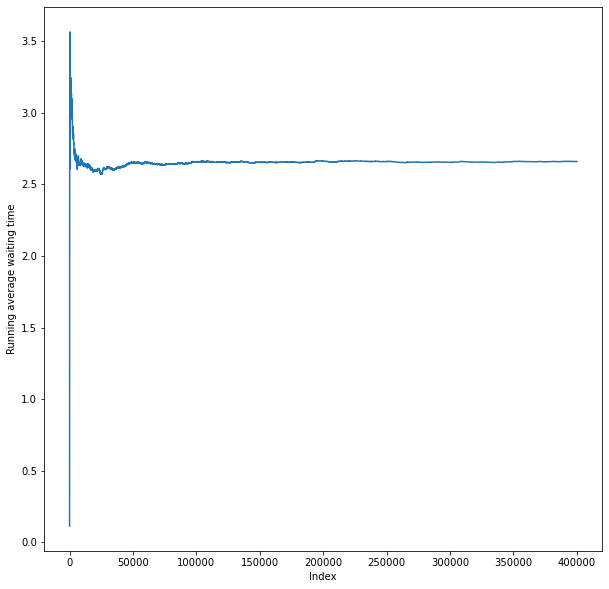

In [16]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), convergence)

#plt.ylim(76, 80)
plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()